# Compare correlation of $\nabla SST$ and $div(\vec{U})$ at different scales at a fixed timestep. 

@author: Lorenzo Francesco Davoli

@creation: 12/05/2025

@contact: l.davoli@campus.unimib.it

@notes: adaptation of the code from GLAUCO project for the paper Meroni et al. (2023)

# Packages

In [1]:
import intake
from easygems import healpix as egh
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
import math
from scipy.stats import sem
from scipy.special import gammaincc
from pycoare import coare_35
import sys
sys.path.append('../../hk25-ShallowCirc/src/')
from toolbox import attach_coords, compute_hder, compute_conv, nest2ring_index
import geometry as gm

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

# Functions

In [2]:
def cells_of_region(ds, region : str):
    '''
    Identify cells in ds (xarray in HealPix coords) corresponding to
    the input region. The "region" argument is an index in the 
    dictionary "regions".
    '''
    if ('lon' not in list(ds.coords)) | ('lat' not in list(ds.coords)):
        raise NameError('Missing coordinates')
    if list(ds.dims)[0] != 'cell':
        raise NameError('Wrong dataset structure')
    if region not in regions.keys():
        raise NameError('Region not defined')
        
    return np.where(
        (ds.lon>np.mod(regions[region]['boundaries'][0],360)) & 
        (ds.lon<np.mod(regions[region]['boundaries'][1],360)) &
        (ds.lat>regions[region]['boundaries'][2]) & 
        (ds.lat<regions[region]['boundaries'][3])
    )[0]

def get_region(ds, region : str):
    '''
    Extract a subset from the xarray ds corresponding to the 
    input region.
    '''
    if 'value' in list(ds.dims):
        return ds.isel(value=cells_of_region(ds, region))        
    elif 'cell' in list(ds.dims):
        return ds.isel(cell=cells_of_region(ds, region))
    

def worldmap(var, extent=None,title=None,**kwargs):
    '''
    Plot variable in a world map using Robinson projection.
    Boundaries can be applied through extent = [minlon,maxlon,minlat,maxlat].
    '''
    projection = ccrs.Robinson(central_longitude=-135.5808361)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    if extent is not None:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    egh.healpix_show(var, ax=ax, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    plt.show()
    
def get_nn_lon_lat_index(nside, lons, lats):
    '''
    Return an xarray.DataArray structure containing HealPix 
    cells in the lon-lat input grid. 
    It is used to regrid HealPix coord to latlon:
        region_idx = get_nn_lon_lat_index(2**healpix_zoom, np.arange(regions[region]['boundaries'][0], regions[region]['boundaries'][1], fine_latlon_gridstep/supersampling['lon']), np.arange(regions[region]['boundaries'][2], regions[region]['boundaries'][3], latlon_gridstep))
        var_lonlat = ds_healpix[var].isel(cell=region_idx).mean()
    '''
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

def get_nside(ds):
    return ds.crs.healpix_nside

def get_nn_data(var, nx=1000, ny=1000, ax=None):
    """
    var: variable (array-like)
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    returns: values on the points in the plot grid.
    """
    lonlat = get_lonlat_for_plot_grid(nx, ny, ax)
    try:
        return get_healpix_nn_data(var, lonlat)
    except ValueError:
        pass
    if set(var.dims) == {"lat", "lon"}:
        return get_lonlat_meshgrid_nn_data(var, lonlat)
    else:
        return get_lonlat_nn_data(var, lonlat)


def get_healpix_nn_data(var, lonlat):
    """
    var: variable on healpix coordinates (array-like)
    lonlat: coordinates at which to get the data
    returns: values on the points in the plot grid.
    """
    valid = np.all(np.isfinite(lonlat), axis=-1)
    points = lonlat[valid].T  # .T reverts index order
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=True, lonlat=True
    )
    res = np.full(lonlat.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return res


def get_lonlat_nn_data(var, lonlat):
    """
    var: variable with lon and lat attributes (2d slice)
    lonlat: coordinates at which to get the data
    returns: values on the points in the plot grid.
    """
    var_xyz = lonlat_to_xyz(lon=var.lon.values.flatten(), lat=var.lat.values.flatten())
    tree = KDTree(var_xyz)

    valid = np.all(np.isfinite(lonlat), axis=-1)
    ll_valid = lonlat[valid].T
    plot_xyz = lonlat_to_xyz(lon=ll_valid[0], lat=ll_valid[1])

    distances, inds = tree.query(plot_xyz)
    res = np.full(lonlat.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var.values.flatten()[inds]
    return res


def get_lonlat_meshgrid_nn_data(var, lonlat):
    """
    var: variable with lon and lat attributes (2d slice)
    lonlat: coordinates at which to get the data
    returns: values on the points in the plot grid.
    """
    return get_lonlat_nn_data(var.stack(cell=("lon", "lat")), lonlat)


def get_lonlat_for_plot_grid(nx, ny, ax=None):
    """
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    returns: coordinates of the points in the plot grid.
    """

    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    lonlat = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    return lonlat


def lonlat_to_xyz(lon, lat):
    """
    lon: longitude in degree E
    lat: latitude in degree N
    returns numpy array (3, len (lon)) with coordinates on unit sphere.
    """

    return np.array(
        (
            np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat)),
            np.sin(np.deg2rad(lon)) * np.cos(np.deg2rad(lat)),
            np.sin(np.deg2rad(lat)),
        )
    ).T

def plot_map_diff(var, ref, colorbar_label="", title="", extent=None, **kwargs):
    """
    var: data set
    ref: reference data
    colorbar_label: label for the colorbar
    title: title string
    **kwargs: get passed to imshow
    returns figure, axis objects
    """
    projection = ccrs.Robinson(central_longitude=-135.5808361)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    if extent is not None:
        ax.set_extent(extent, crs=ccrs.PlateCarree())

    varmap = get_nn_data(var, ax=ax)
    refmap = get_nn_data(ref, ax=ax)
    imsh = ax.imshow(
        varmap - refmap, extent=ax.get_xlim() + ax.get_ylim(), origin="lower", **kwargs
    )

    # Add coastlines, borders and gridlines
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # Colorbar and title
    fig.colorbar(imsh, label=colorbar_label)
    plt.title(title)
    return (fig, ax)


def compute_SST_wind_derivative_fields(str_a,str_b,sigma,llon,llat,sst,u_interp,v_interp):
    # Get the large scale wind and sst field to compute anomalies.
    smooth_u = gm.nan_gaussian_filter(u_interp,sigma)
    smooth_v = gm.nan_gaussian_filter(v_interp,sigma)
    # Ensure we remove land (sst != np.nan)
    smooth_u[np.isnan(sst)] = np.nan
    smooth_v[np.isnan(sst)] = np.nan
    # Wind speed
    smooth_ws = np.sqrt(smooth_u**2+smooth_v**2)
    
    # Large-scale winddir
    cosphi = smooth_u/smooth_ws
    sinphi = smooth_v/smooth_ws
    
    # Get the anomalies with respect to the background wind field.
    u_prime = u_interp-smooth_u
    v_prime = v_interp-smooth_v
    
    dsst_dx, dsst_dy = gm.grad_sphere(sst,llon,llat)
    if str_a=='gamma':
        a_field = u_interp*dsst_dx + v_interp*dsst_dy
    elif str_a=='dsst_dr':
        a_field = dsst_dx*cosphi + dsst_dy*sinphi
    elif str_a=='dsst_prime_dr':
        smooth_sst = gm.nan_gaussian_filter(sst,sigma)
        sst_prime = sst-smooth_sst
        dsst_prime_dx, dsst_prime_dy = gm.grad_sphere(sst_prime,llon,llat)
        a_field = dsst_prime_dx*cosphi + dsst_prime_dy*sinphi
    elif str_a=='lapl_sst':
        a_field = gm.div_sphere(dsst_dx,dsst_dy,llon,llat)
    elif str_a=='d2sst_ds2':
        dsst_ds = -dsst_dx*sinphi + dsst_dy*cosphi
        ddsst_ds_dx, ddsst_ds_dy = gm.grad_sphere(dsst_ds,llon,llat)
        a_field = -ddsst_ds_dx*sinphi + ddsst_ds_dy*cosphi
    elif str_a=='d2sst_prime_ds2':
        smooth_sst = gm.nan_gaussian_filter(sst,sigma)
        sst_prime = sst-smooth_sst
        dsst_prime_dx, dsst_prime_dy = gm.grad_sphere(sst_prime,llon,llat)
        dsst_prime_ds = -dsst_prime_dx*sinphi + dsst_prime_dy*cosphi
        ddsst_prime_ds_dx, ddsst_prime_ds_dy = gm.grad_sphere(dsst_prime_ds,llon,llat)
        a_field = -ddsst_prime_ds_dx*sinphi + ddsst_prime_ds_dy*cosphi
    elif str_a=='sst_prime':
        smooth_sst = gm.nan_gaussian_filter(l3_sst,sigma)
        a_field = l3_sst-smooth_sst
		
    if str_b=='wind_div':
        b_field = gm.div_sphere(u_interp,v_interp,llon,llat)
    elif str_b=='dr_dot_prime_dr':
        r_dot_prime = u_prime*cosphi + v_prime*sinphi
        dr_dot_prime_dx, dr_dot_prime_dy = gm.grad_sphere(r_dot_prime,llon,llat)
        b_field = dr_dot_prime_dx*cosphi + dr_dot_prime_dy*sinphi 
    elif str_b=='ds_dot_prime_ds':
        s_dot_prime = -u_prime*sinphi + v_prime*cosphi
        ds_dot_prime_dx, ds_dot_prime_dy = gm.grad_sphere(s_dot_prime,llon,llat)
        b_field = -ds_dot_prime_dx*sinphi + ds_dot_prime_dy*cosphi
    elif str_b=='ws_prime':
        b_field = np.sqrt(u_interp**2+v_interp**2)-smooth_ws

    return a_field, b_field, smooth_ws


def compute_SST_var_derivative_fields(str_a,str_b,sigma,llon,llat,sst,u_interp,v_interp,var):
    # Get the background wind field.
    smooth_u = gm.nan_gaussian_filter(u_interp,sigma)
    smooth_v = gm.nan_gaussian_filter(v_interp,sigma)
    smooth_ws = np.sqrt(smooth_u**2+smooth_v**2)
    
    # Large-scale winddir
    cosphi = smooth_u/smooth_ws
    sinphi = smooth_v/smooth_ws

    dsst_dx, dsst_dy = gm.grad_sphere(sst,llon,llat)
    if str_a=='gamma':
        a_field = u_interp*dsst_dx + v_interp*dsst_dy
    elif str_a=='dsst_dr':
        a_field = dsst_dx*cosphi + dsst_dy*sinphi
    elif str_a=='dsst_prime_dr':
        smooth_sst = gm.nan_gaussian_filter(sst,sigma)
        sst_prime = sst-smooth_sst
        dsst_prime_dx, dsst_prime_dy = gm.grad_sphere(sst_prime,llon,llat)
        a_field = dsst_prime_dx*cosphi + dsst_prime_dy*sinphi
    elif str_a=='lapl_sst':
        a_field = gm.div_sphere(dsst_dx,dsst_dy,llon,llat)
    elif str_a=='d2sst_ds2':
        dsst_ds = -dsst_dx*sinphi + dsst_dy*cosphi
        ddsst_ds_dx, ddsst_ds_dy = gm.grad_sphere(dsst_ds,llon,llat)
        a_field = -ddsst_ds_dx*sinphi + ddsst_ds_dy*cosphi
    elif str_a=='d2sst_prime_ds2':
        smooth_sst = gm.nan_gaussian_filter(sst,sigma)
        sst_prime = sst-smooth_sst
        dsst_prime_dx, dsst_prime_dy = gm.grad_sphere(sst_prime,llon,llat)
        dsst_prime_ds = -dsst_prime_dx*sinphi + dsst_prime_dy*cosphi
        ddsst_prime_ds_dx, ddsst_prime_ds_dy = gm.grad_sphere(dsst_prime_ds,llon,llat)
        a_field = -ddsst_prime_ds_dx*sinphi + ddsst_prime_ds_dy*cosphi
    elif str_a=='sst_prime':
        smooth_sst = gm.nan_gaussian_filter(l3_sst,sigma)
        a_field = l3_sst-smooth_sst
    
    smooth_var = gm.nan_gaussian_filter(var,sigma)
    var_prime = var-smooth_var
    dvar_dx, dvar_dy = gm.grad_sphere(var_prime,llon,llat)
    if str_b=='dblh_prime_dr':
        b_field = dvar_dx*cosphi + dvar_dy*sinphi
    elif str_b=='dblh_prime_ds':
        b_field = -dvar_dx*sinphi + dvar_dy*cosphi    
    else: 
        raise NameError('Field not recognised')
    
    return a_field, b_field, smooth_ws


def weighted_linear_regression_with_pvalues(x, y, sigma_y):
    '''         
        Compute a weighted linear regressio of (x,y+/-sigma_y),
        where the uncertainty on y observations is taken into 
        account.
        Returns a dictionary in the form:
                "intercept" : (intercept, sigma_b),
                "slope" : (slope, sigma_m),
                "chi2" : chi square value,
                "q" : goodness of fit

        From Numerical Recipe 15.2
        If q is larger than, say, 0.1,then the goodness-of-fit is believable. 
        If it is larger than, say, 0.001, then the fit may be acceptable if the 
        errors are nonnormal or have been moderately underestimated. If q is 
        less than 0.001, then the model and/or estimation procedure can rightly
        be called into question. In this latter case, turn to 15.7 to proceed 
        further.
    '''

    # Numerical recipe code 15.2 (https://numerical.recipes/book.html)
    # Translated to python by copilot and checked.
    ndata = len(x)
    x = np.array(x)
    y = np.array(y)
    sigma_y = np.array(sigma_y)
    
    ss = 0.0
    sx = 0.0
    sy = 0.0
    st2 = 0.0
    b = 0.0
    chi2 = 0.0
    q = 1.0 # Estimator for goodness of fit.
    
    '''
        From Numerical Recipe 15.2
        If Q is larger than, say, 0.1,then the goodness-of-fit is believable. 
        If it is larger than, say, 0.001, then the fit may be acceptable if the 
        errors are nonnormal or have been moderately underestimated. If Q is 
        less than 0.001, then the model and/or estimation procedure can rightly
        be called into question. In this latter case, turn to 15.7 to proceed 
        further.
    '''

    for i in range(ndata):
        wt = 1.0 / (sigma_y[i] ** 2)
        ss += wt
        sx += x[i] * wt
        sy += y[i] * wt

    sxoss = sx / ss

    for i in range(ndata):
        t = (x[i] - sxoss) / sigma_y[i]
        st2 += t * t
        b += t * y[i] / sigma_y[i]

    b /= st2
    a = (sy - sx * b) / ss
    sigma_a = np.sqrt((1.0 + sx * sx / (ss * st2)) / ss)
    sigma_b = np.sqrt(1.0 / st2)

    for i in range(ndata):
        chi2 += ((y[i] - a - b * x[i]) / sigma_y[i]) ** 2

    if ndata > 2:
        q = gammaincc(0.5 * (ndata - 2), 0.5 * chi2)

    return {
        "intercept": (a, sigma_a),
        "slope": (b, sigma_b),
        "chi2" : chi2,
        "q" : q,
    }
    

def binned_weighted_lin_regr(x, y, bins=10):
    """
    Bin x into equally spaced intervals and compute the lin regr y(x) considering std(y) for each bin.
    
    Parameters:
    - x: array-like, independent variable
    - y: array-like, dependent variable
    - bins: int, number of bins
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Compute bin edges and indices
    bin_edges = np.linspace(np.nanmin(x), np.nanmax(x), bins + 1)
    bin_indices = np.digitize(x, bin_edges) - 1  # bins are 0-indexed

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    mean_y = np.array([
        np.nanmean(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan
        for i in range(bins)
    ])
    std_y = np.array([
        np.nanstd(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan
        for i in range(bins)
    ])

    bin_centers, mean_y, std_y = bin_centers[np.isfinite(mean_y) & np.isfinite(std_y) & (std_y != 0)], mean_y[np.isfinite(mean_y) & np.isfinite(std_y) & (std_y != 0)], std_y[np.isfinite(mean_y) & np.isfinite(std_y) & (std_y != 0)]

    return weighted_linear_regression_with_pvalues(bin_centers, mean_y, std_y)
    
def binned_mean_plot(x, y, bins=10, xlabel='x', ylabel='Mean y',title=None):
    """
    Bin x into equally spaced intervals and compute mean y in each bin.
    
    Parameters:
    - x: array-like, independent variable
    - y: array-like, dependent variable
    - bins: int, number of bins
    - xlabel: str, label for x-axis
    - ylabel: str, label for y-axis
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Compute bin edges and indices
    bin_edges = np.linspace(np.nanmin(x), np.nanmax(x), bins + 1)
    bin_indices = np.digitize(x, bin_edges) - 1  # bins are 0-indexed

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    mean_y = np.array([
        np.nanmean(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan
        for i in range(bins)
    ])
    std_y = np.array([
        np.nanstd(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan
        for i in range(bins)
    ])

    lin_regr = binned_weighted_lin_regr(x, y, bins=10)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    plt.errorbar(x=bin_centers,y=mean_y,yerr=std_y,marker='o', linestyle='-', color='black')
    plt.plot(bin_centers,lin_regr['intercept'][0]+bin_centers*lin_regr['slope'][0],marker='', linestyle='-', color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()
    
    print(lin_regr)
    

def plot_map_with_contours(data,llat,llon,background=None,title=None,cmap=None,vmin=None,vmax=None,xlim=None,ylim=None,label=None, contour_levels=10):
    """
    Plot a 2D data array on a map with optional background contours.

    Parameters:
    - data: 2D array (lat x lon)
    - llat, llon: 2D arrays matching shape of data
    - background: Optional 2D array (same shape) to use as contour overlay
    - title: Plot title
    - cmap: Colormap for main data
    - contour_levels: Number or list of contour levels
    """
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Main data plot
    mesh = ax.pcolormesh(llon, llat, data, transform=ccrs.PlateCarree(), cmap=cmap,vmin=vmin,vmax=vmax)

    # Add optional contours
    if background is not None:
        contours = ax.contour(llon, llat, background, levels=contour_levels, colors='black',
                              linewidths=0.6, transform=ccrs.PlateCarree())
        ax.clabel(contours, inline=True, fontsize=8)

    if xlim != None and ylim != None:
        ax.set_xlim(xlim[0],xlim[1])
        ax.set_ylim(ylim[0],ylim[1])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--')
    plt.colorbar(mesh, ax=ax, orientation='vertical', label=label,shrink=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def runCOARE(ds, uas, vas, psl, sst, tas, hur, pr, rsds, rlds, lat_name='lat', lon_name='lon'):
    ''' COARE requires the following input atmospheric variables:
        source: https://github.com/pyCOARE/coare/blob/main/pycoare/coare_35.py

        u: ocean surface wind speed (m/s) at height zu
        t: bulk air temperature (degC) at height zt
        rh: relative humidity (%) at height zq
        ts: sea water temperature (degC) (also see jcool)
        p: surface air pressure (mb)
        zi: planetary boundary layer height (m)
        rs: downward shortwave radiation (W/m^2)
        rl: downward longwave radiation (W/m^2)
        rain: rain rate (mm/hr)

        Note: ocean variables and sensor heights ignored and set to COARE default for now.

        Inputs to this wrapping function:
            - IFS dataset with all atmospheric variables
            - Each atmospheric variable as: ds["var"]
            - Names of your lat/lon coordinates (if different from standard)

        Output: Dataset inputted into function with processed atmospheric variables
                & variable of interest from COARE (in this case wind stress).
                See source for other COARE variables (good luck, COARE code is a handful).

    '''
    # define shape of grid
    dimensions = list(ds.dims)
    grid_shape = tas.shape

    # compute wind speed from wind vectors
    ds['wsp'] = ((lat_name, lon_name), np.sqrt(uas**2 + vas**2).data)

    # express pressure as hPa instead of Pa
    ds['psl'] = ds['psl'] * 0.01

    # express sst and temp air as deg C not K
    ds['sst'] = ds['sst']- 273.15
    ds['tas'] = ds['tas'] - 273.15

    # express relative humidity in %
    ds['hur'] = ds['hur'] * 100

    # convert rain rate from kg/m2/s to mm/hr
    ds['pr'] = ds['pr'] * 3600

    # run COARE
    bulk_params = coare_35(u = ds["wsp"].data.flatten(), t = ds["tas"].data.flatten(),
                            rh = ds["hur"].data.flatten(), ts = ds["sst"].data.flatten(),
                            p = ds["psl"].data.flatten(), rs = ds["rsds"].data.flatten(),
                            rl = ds["rlds"].data.flatten(), rain = ds["pr"].data.flatten())

    # retrieve variable of interest (in this case wind stress)
    ds['cwst'] = (dimensions, bulk_params._return_vars('tau').reshape(grid_shape))
    ds['ccdrag'] = (dimensions, bulk_params._return_vars('cd').reshape(grid_shape))
    ds['ccdragn'] = (dimensions, bulk_params._return_vars('cdn_rf').reshape(grid_shape))

    return ds


# Data extraction

## Define regions and day

In [3]:
regions = {
    'gulf_stream' : {
        'long_name' : 'Gulf Stream',
        'short_name' : 'gulf_stream',
        'boundaries' : [-83,-30,30,55], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
        'sst_range' : [270,305],
        'detail_boundaries' : [-50,-47.5,40,42.5],
    },    
    'gulf_stream_detail' : {
        'long_name' : 'Gulf Stream - detail',
        'short_name' : 'gulf_stream_detail',
        'boundaries' : [-73,-50,30,45], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
        'sst_range' : [270,305],
    },    
    'tropical_atlantic' : {
        'long_name' : 'Tropical Atlantic',
        'short_name' : 'tropical_atlantic',
        'boundaries' : [-62,15,-20,20], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
        'sst_range' : [290,305],
    },
    'tropical_atlantic_detail' : {
        'long_name' : 'Tropical Atlantic - detail',
        'short_name' : 'tropical_atlantic_detail',
        'boundaries' : [-40,-25,-5,0], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
        'sst_range' : [290,305],
    },
    'eurec4a' : {
        'long_name' : '$EUREC^{4}A$',
        'short_name' : 'eurec4a',
        'boundaries' : [-62,-48,4,16], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
        'sst_range' : [290,305],
    },
    'eurec4a_extended' : {
        'long_name' : r'extended $EUREC^{4}A$',
        'short_name' : 'eurec4a_extended',
        'boundaries' : [-62,-20,0,20], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
        'sst_range' : [290,305],
        'detail_boundaries' : [-50,-47.5,10,12.5],
    },
    'EAC' : {
        'long_name' : r'East Australian Current',
        'short_name' : 'EAC',
        'boundaries' : [150,165,-45,-25], # [minlon,maxlon,minlat,maxlat]. lon -> [-180,180], lat -> [-90,90]  
        'sst_range' : [290,305],
    },
}

region = 'eurec4a_extended'
#region = 'gulf_stream'
#region = 'EAC'

# Define time to extract. 
# Note: different zooms/products may have different starting time, 
# and therefore a different phase.
fine_time = '2020-03-01T00:00:00.000000000'
coarse_time = '2020-03-01T00:00:00.000000000'

## Catalog

In [4]:
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["EU"]
list(cat)

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'arp-gem-1p3km',
 'arp-gem-2p6km',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco2559_rcbmf',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'ifs_tco3999_rcbmf',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

## Extract fine (zoom 11) and coarse (zoom 7) ds

In [5]:
# 'ifs_tco3999-ng5_rcbmf' wasn't working in servers with
# more than 10GB, so I'm using the '_cf' version.
# Minor adaptations are required to switch back to the original.
model='ifs_tco3999-ng5_rcbmf_cf'

print(pd.DataFrame(cat[model].describe()["user_parameters"]))

time_res = 'PT1H'

fine_zoom = 11
fine_ds = cat[model](zoom=fine_zoom,time=time_res).to_dask().sel(time=fine_time)

coarse_zoom = 7
coarse_ds = cat[model](zoom=coarse_zoom,time=time_res).to_dask().sel(time=coarse_time)

   name                     description type  allowed default
0  time  time resolution of the dataset  str   [PT1H]    PT1H
1  zoom       zoom level of the dataset  int  [7, 11]       7


/home/b/b383497/.conda/envs/easy/lib/python3.12/site-packages/intake_xarray/xzarr.py:46: UserWarning: The specified chunks separate the stored chunks along dimension "cell" starting at index 33554432. This could degrade performance. Instead, consider rechunking after loading.
  self._ds = xr.open_dataset(self.urlpath, **kw)


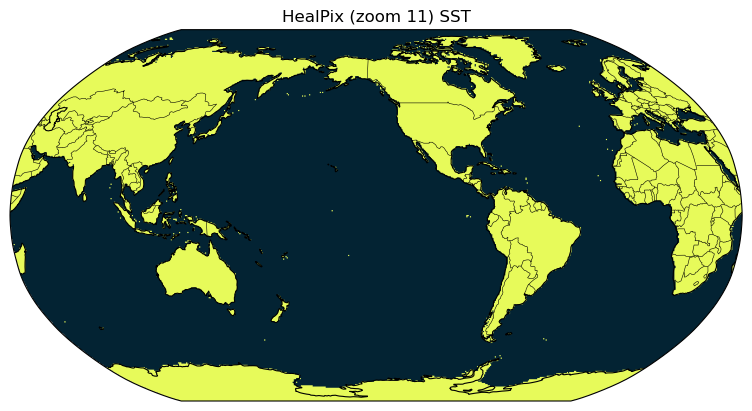

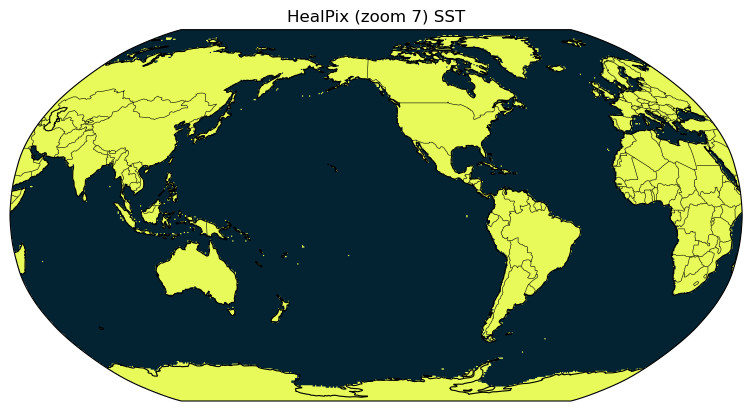

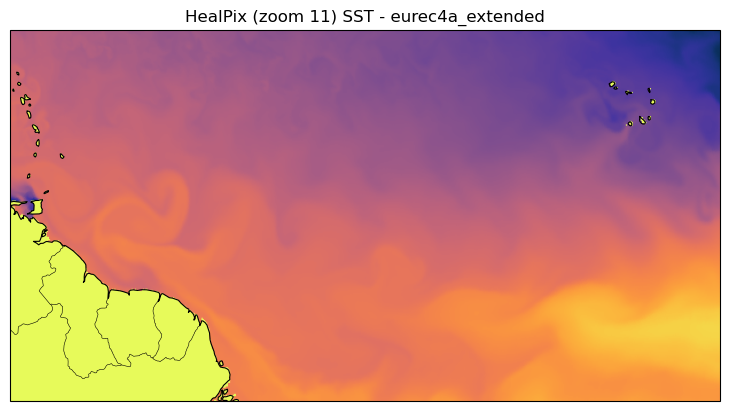

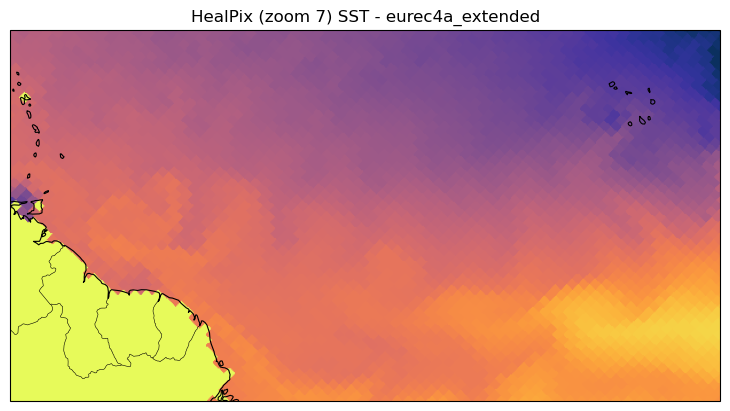

In [6]:
if True:
    # Test
    worldmap(fine_ds.sst, cmap=cmocean.cm.thermal,title=f'HealPix (zoom {fine_zoom}) SST',vmin=None,vmax=None)
    worldmap(coarse_ds.sst, cmap=cmocean.cm.thermal,title=f'HealPix (zoom {coarse_zoom}) SST',vmin=None,vmax=None)
    worldmap(fine_ds.sst, cmap=cmocean.cm.thermal,extent=regions[region]['boundaries'],title=f'HealPix (zoom {fine_zoom}) SST - {region}',vmin=regions[region]['sst_range'][0],vmax=regions[region]['sst_range'][1])    
    worldmap(coarse_ds.sst, cmap=cmocean.cm.thermal,extent=regions[region]['boundaries'],title=f'HealPix (zoom {coarse_zoom}) SST - {region}',vmin=regions[region]['sst_range'][0],vmax=regions[region]['sst_range'][1])


# Analyses

## Zoom 11 and zoom 7 comparison - HealPix and lonlat

### SST anomaly from HealPix dataset (not smoothed)

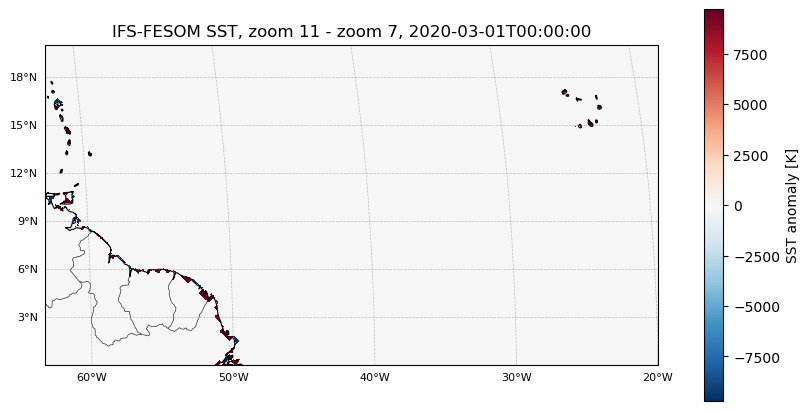

In [7]:
if True:
    if region == 'eurec4a_extended':
        vmin = None
        vmax = None
    if region == 'gulf_stream':
        vmin = None
        vmax = None
        
    fig, ax = plot_map_diff(
        fine_ds.sst,
        coarse_ds.sst,
        cmap="RdBu_r",
        vmin=vmin,
        vmax=vmax,
        interpolation="none",
        extent=regions[region]['boundaries'],
        colorbar_label="SST anomaly [K]",
        title=f"IFS-FESOM SST, zoom 11 - zoom 7, {str(fine_ds.time.values)[:19]}",
    )
    ax.grid()
    plt.show()

### HealPix to latlon regridding

#### Zoom 11

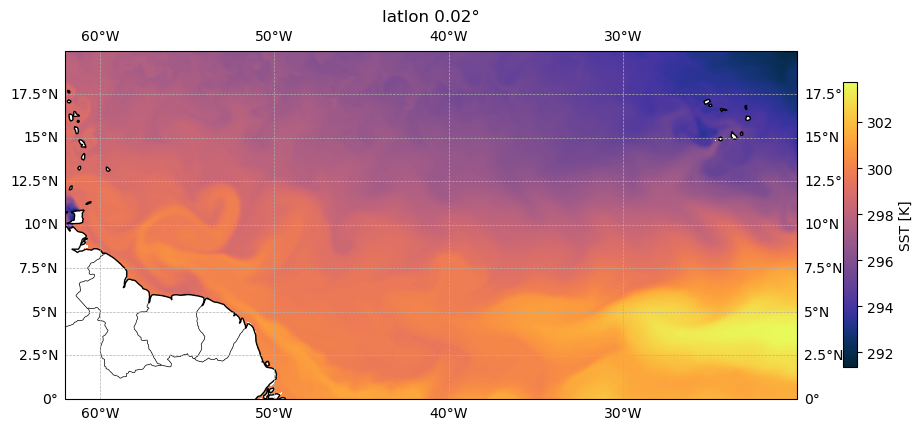

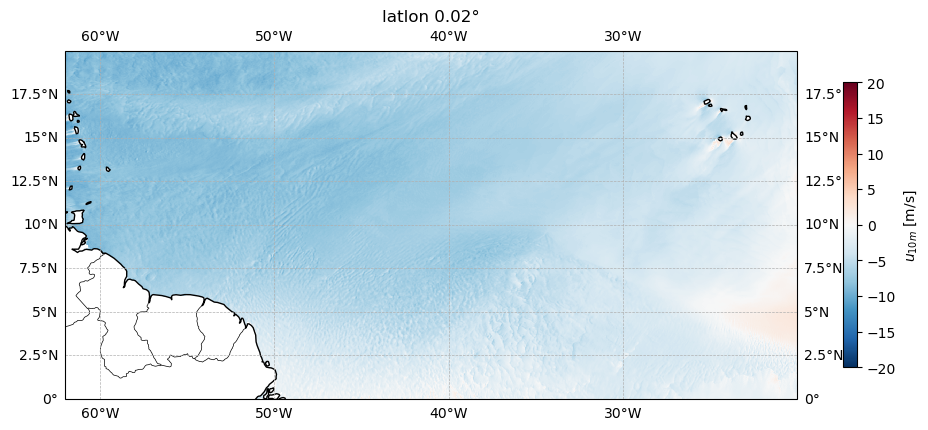

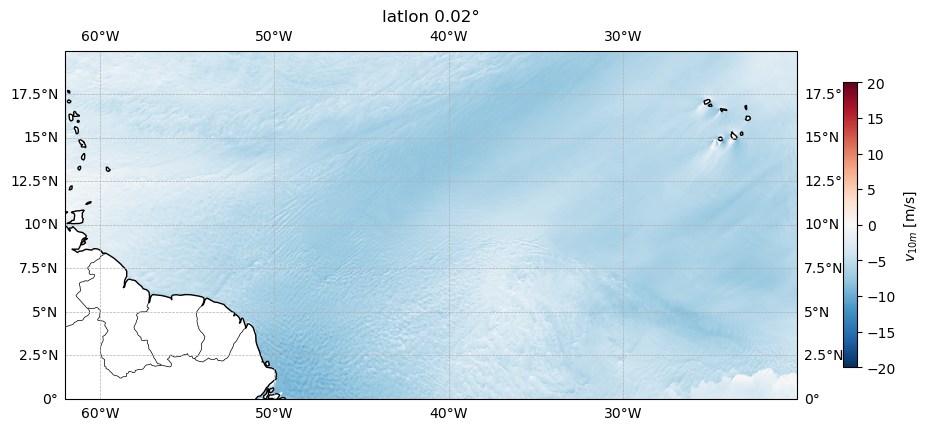

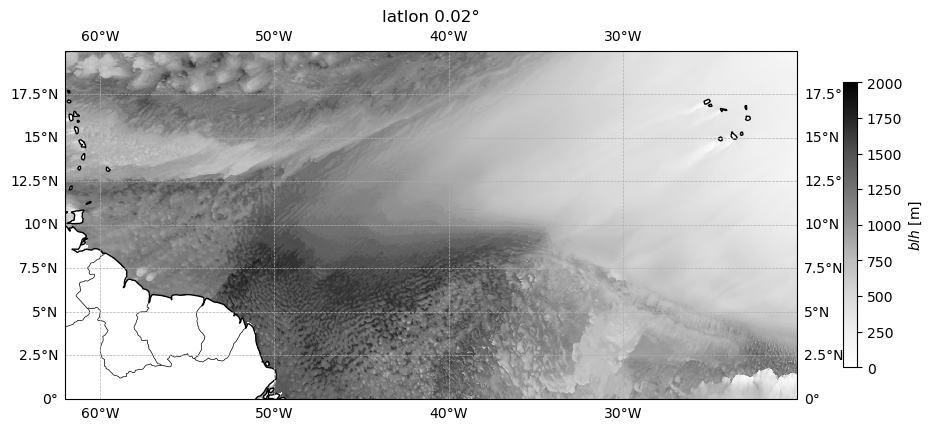

In [8]:
fine_latlon_gridstep = 0.02 # [°], see https://easy.gems.dkrz.de/Processing/healpix/index.html#healpix-spatial-resolution
for var in fine_ds.data_vars:
    if np.issubdtype(fine_ds[var].dtype, np.floating):
        # Rule out FillValues
        fine_ds[var] = fine_ds[var].where(fine_ds[var] != 9999, np.nan)

# Need to drop the pre-existing vars to avoid duplicates.
fine_ds = fine_ds.drop_vars(['lat','lon'])

if True: # Correct for aliasing 
    supersampling = {"lon": 4, "lat": 4}
    region_idx = get_nn_lon_lat_index(2**fine_zoom, np.arange(regions[region]['boundaries'][0], regions[region]['boundaries'][1], fine_latlon_gridstep/supersampling['lon']), np.arange(regions[region]['boundaries'][2], regions[region]['boundaries'][3], fine_latlon_gridstep/supersampling['lat']))
    # Computing here optimizes the total execution time for the current 
    # state of the analysis, but it might not be beneficial if you want to do some
    # further operations on the data.
    fine_sst = fine_ds.sst.where(fine_ds.sst!=9999).isel(cell=region_idx).coarsen(supersampling).mean().compute()
    fine_10u = fine_ds['uas'].isel(cell=region_idx).coarsen(supersampling).mean().compute()
    fine_10v = fine_ds['vas'].isel(cell=region_idx).coarsen(supersampling).mean().compute()
    fine_blh = fine_ds['blh'].isel(cell=region_idx).coarsen(supersampling).mean().compute()
    fine_cc = fine_ds['cc'].isel(cell=region_idx).sum(dim='level').coarsen(supersampling).mean().compute()
else:
    region_idx = get_nn_lon_lat_index(2**fine_zoom, np.arange(regions[region]['boundaries'][0], regions[region]['boundaries'][1], fine_latlon_gridstep), np.arange(regions[region]['boundaries'][2], regions[region]['boundaries'][3], fine_latlon_gridstep))
    fine_sst = fine_ds.sst.isel(cell=region_idx).compute()
    fine_10u = fine_ds['10u'].isel(cell=region_idx).compute()
    fine_10v = fine_ds['10v'].isel(cell=region_idx).compute()

# Remove land
fine_sst = fine_sst.where(np.isfinite(fine_sst))
fine_10u = fine_10u.where(np.isfinite(fine_sst))
fine_10v = fine_10v.where(np.isfinite(fine_sst))
fine_blh = fine_blh.where(np.isfinite(fine_sst))
fine_cc = fine_cc.where(np.isfinite(fine_sst))

fine_llon, fine_llat = np.meshgrid(fine_sst.lon,fine_sst.lat)

if True:
    plot_map_with_contours(fine_sst, fine_llat, fine_llon, background=None, title=f'latlon {fine_latlon_gridstep}°', cmap=cmocean.cm.thermal,label=r'SST [K]')
    plot_map_with_contours(fine_10u, fine_llat, fine_llon, background=None, title=f'latlon {fine_latlon_gridstep}°', cmap='RdBu_r',vmin=-20,vmax=20,label=r'$u_{10m}$ [m/s]',contour_levels=5)
    plot_map_with_contours(fine_10v, fine_llat, fine_llon, background=None, title=f'latlon {fine_latlon_gridstep}°', cmap='RdBu_r',vmin=-20,vmax=20,label=r'$v_{10m}$ [m/s]',contour_levels=5)
    plot_map_with_contours(fine_blh, fine_llat, fine_llon, background=None, title=f'latlon {fine_latlon_gridstep}°', cmap='Greys',vmin=0,vmax=2000,label=r'$blh$ [m]',contour_levels=5)


#### Zoom 7

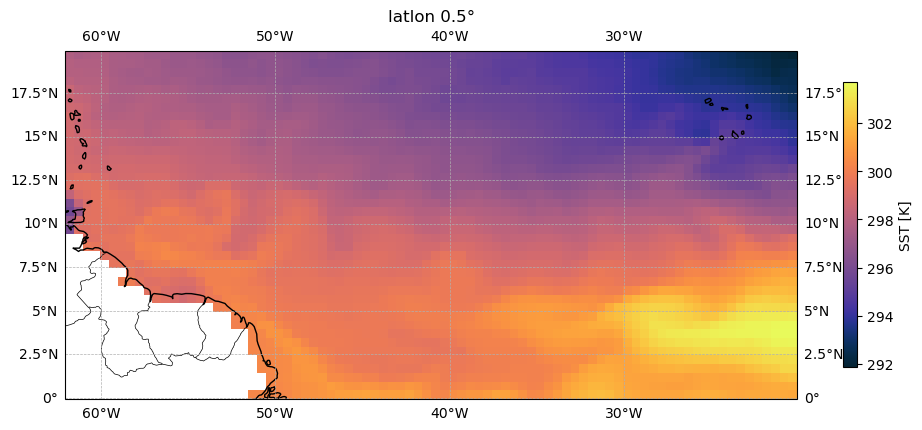

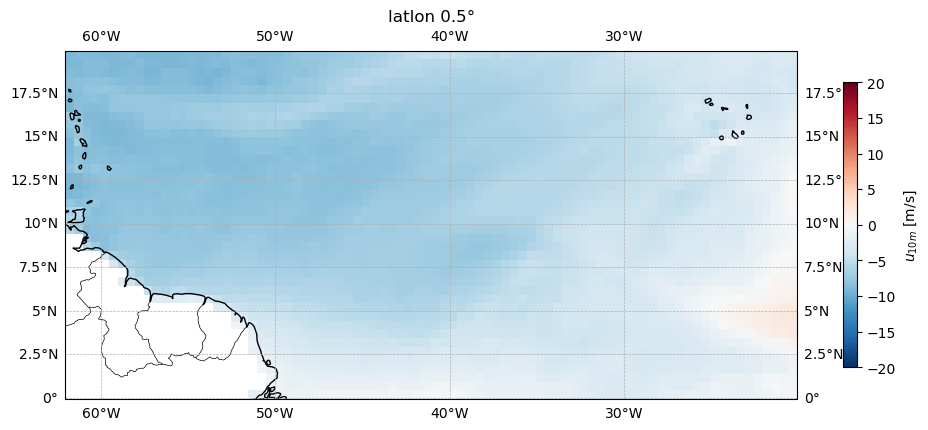

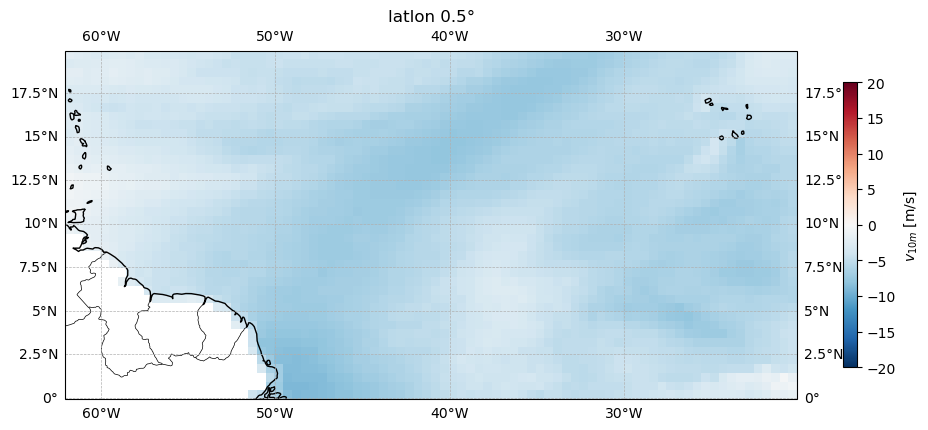

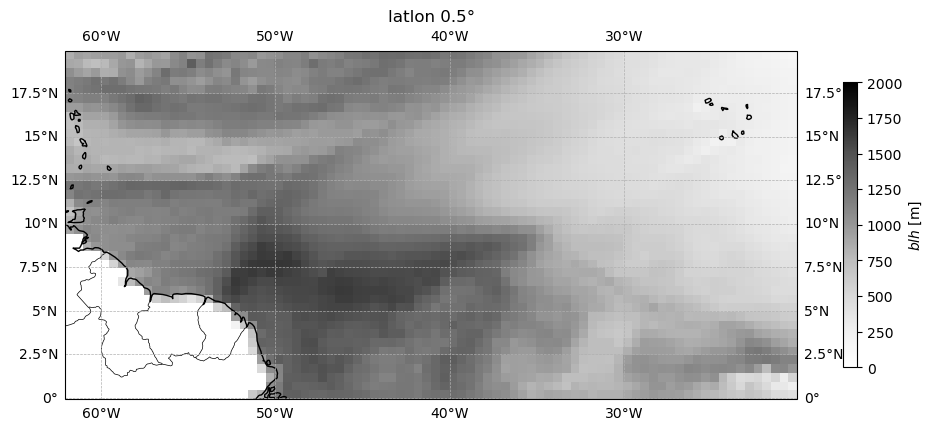

In [9]:
coarse_latlon_gridstep = 0.5 # [°], see https://easy.gems.dkrz.de/Processing/healpix/index.html#healpix-spatial-resolution
for var in coarse_ds.data_vars:
    if np.issubdtype(coarse_ds[var].dtype, np.floating):
        # Rule out FillValues
        coarse_ds[var] = coarse_ds[var].where(coarse_ds[var] != 9999, np.nan)
        
# Need to drop the pre-existing vars to avoid duplicates.
coarse_ds = coarse_ds.drop_vars(['lat','lon'])

if True: # Correct for aliasing
    supersampling = {"lon": 4, "lat": 4}
    region_idx = get_nn_lon_lat_index(2**coarse_zoom, np.arange(regions[region]['boundaries'][0], regions[region]['boundaries'][1], coarse_latlon_gridstep/supersampling['lon']), np.arange(regions[region]['boundaries'][2], regions[region]['boundaries'][3], coarse_latlon_gridstep/supersampling['lat']))
    coarse_sst = coarse_ds.sst.where(coarse_ds.sst!=9999).isel(cell=region_idx).coarsen(supersampling).mean().compute()
    # Computing here optimizes the total execution time for the current 
    # state of the analysis, but it might not be beneficial if you want to do some
    # further operations on the data.
    coarse_10u = coarse_ds['uas'].isel(cell=region_idx).coarsen(supersampling).mean().compute()
    coarse_10v = coarse_ds['vas'].isel(cell=region_idx).coarsen(supersampling).mean().compute()
    coarse_blh = coarse_ds['blh'].isel(cell=region_idx).coarsen(supersampling).mean().compute()
    coarse_cc = coarse_ds['cc'].isel(cell=region_idx).sum(dim='level').coarsen(supersampling).mean().compute()
else:
    region_idx = get_nn_lon_lat_index(2**coarse_zoom, np.arange(regions[region]['boundaries'][0], regions[region]['boundaries'][1], coarse_latlon_gridstep), np.arange(regions[region]['boundaries'][2], regions[region]['boundaries'][3], coarse_latlon_gridstep))
    coarse_sst = coarse_ds.sst.isel(cell=region_idx).compute()
    coarse_10u = coarse_ds['10u'].isel(cell=region_idx).compute()
    coarse_10v = coarse_ds['10v'].isel(cell=region_idx).compute()

# Remove land
coarse_sst = coarse_sst.where(np.isfinite(coarse_sst))
coarse_10u = coarse_10u.where(np.isfinite(coarse_sst))
coarse_10v = coarse_10v.where(np.isfinite(coarse_sst))
coarse_blh = coarse_blh.where(np.isfinite(coarse_sst))
coarse_cc = coarse_cc.where(np.isfinite(coarse_sst))

coarse_llon, coarse_llat = np.meshgrid(coarse_sst.lon,coarse_sst.lat)

if True:
    plot_map_with_contours(coarse_sst, coarse_llat, coarse_llon, background=None, title=f'latlon {coarse_latlon_gridstep}°', cmap=cmocean.cm.thermal,label=r'SST [K]')
    plot_map_with_contours(coarse_10u, coarse_llat, coarse_llon, background=None, title=f'latlon {coarse_latlon_gridstep}°', cmap='RdBu_r',vmin=-20,vmax=20,label=r'$u_{10m}$ [m/s]',contour_levels=5)
    plot_map_with_contours(coarse_10v, coarse_llat, coarse_llon, background=None, title=f'latlon {coarse_latlon_gridstep}°', cmap='RdBu_r',vmin=-20,vmax=20,label=r'$v_{10m}$ [m/s]',contour_levels=5)
    plot_map_with_contours(coarse_blh, coarse_llat, coarse_llon, background=None, title=f'latlon {coarse_latlon_gridstep}°', cmap='Greys',vmin=0,vmax=2000,label=r'$blh$ [m]',contour_levels=5)


### SST anomaly from lonlat

/home/b/b383497/hk25-teams/hk25-ASintTrops/notebooks/geometry.py:117: RuntimeWarning: divide by zero encountered in divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
/home/b/b383497/hk25-teams/hk25-ASintTrops/notebooks/geometry.py:117: RuntimeWarning: invalid value encountered in divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field


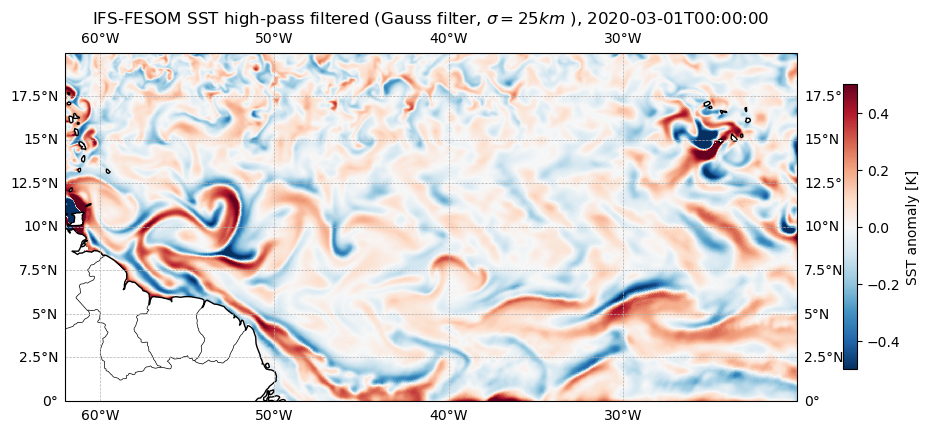

In [10]:
if True:
    if region == 'eurec4a_extended':
        vmin = -0.5
        vmax = 0.5
    if region == 'gulf_stream':
        vmin = -2
        vmax = 2
    coarse_scale_equiv_sigma = 25 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 25km gaussian smoothing => ~50km filter, equiv to resolution of ifs_zoom = 7
    coarse_scale_equiv_sigma_sst = gm.nan_gaussian_filter(fine_sst,coarse_scale_equiv_sigma)
    
    sst_diff = fine_sst-coarse_scale_equiv_sigma_sst
    
    plot_map_with_contours(sst_diff, fine_llat, fine_llon, title=rf"IFS-FESOM SST high-pass filtered (Gauss filter, $\sigma = 25km$ ), {str(fine_ds.time.values)[:19]}", cmap='RdBu_r', vmin=vmin, vmax=vmax,label='SST anomaly [K]')

# SST-wind coupling (zoom 11, different scales)

## Sub-mesoscale

In [11]:
llon,llat = fine_llon,fine_llat

# High pass filter defining the upper limit of the submesoscale  
high_pass_sigma = 5 # [gridstep], for ifs_zoom = 11 => 0.02° latlon resampled grid => 10km gaussian kernel 

### DMM

In [ ]:
'''
Select here the mechanism to be analysed.
DMM = coupling between along-wind gradient of SST and along-wind divergence of wind speed anomaly
DMM_anomalies = coupling between along-wind gradient of SST anomaly and along-wind divergence 
    of wind speed anomaly 
PA = coupling between across-wind laplacian of SST and across-wind divergence of wind speed anomaly
PA_anomalies = coupling between across-wind laplacian of SST anomaly and across-wind divergence 
    of wind speed anomaly 

Note: plot labels need to be adjusted accordingly.
'''
str_mech = 'DMM_anomalies'
if str_mech == 'DMM':
    sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'dsst_prime_dr', 'lapl_sst', 'd2sst_ds2', 'd2sst_prime_ds2', 'sst_prime'
    wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    var_deriv = 'dblh_prime_dr' # Choose between: 'dblh_prime_dr', 'dblh_prime_ds'
elif str_mech == 'DMM_anomalies': # Use sst gradients of anomaly instead of original field.
    sst_deriv = 'dsst_prime_dr' 
    wind_deriv = 'dr_dot_prime_dr'
    var_deriv = 'dblh_prime_dr' 
elif str_mech == 'PA':
    sst_deriv = 'd2sst_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    var_deriv = 'dblh_prime_ds'
elif str_mech == 'PA_anomalies':
    sst_deriv = 'd2sst_prime_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    var_deriv = 'dblh_prime_ds'
else: 
    raise NameError('Mechanism not recognised')

# SST grad and wind div along large-scale wind direction
sst_field, wind_field, _ = compute_SST_wind_derivative_fields(sst_deriv,wind_deriv,high_pass_sigma,llon,llat,fine_sst,fine_10u,fine_10v)
binned_mean_plot(sst_field.flatten(), wind_field.flatten(), bins=20, xlabel=r"$\frac{d \, SST'}{dr}$ [K m-1]", ylabel=r"$\frac{d \, u'}{dr}$ [s-1]",title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km)')

_, blh_field, _ = compute_SST_var_derivative_fields(sst_deriv,var_deriv,high_pass_sigma,llon,llat,fine_sst,fine_10u,fine_10v,fine_blh)
binned_mean_plot(sst_field.flatten(), blh_field.flatten(), bins=20, xlabel=r"$\frac{d \, SST'}{dr}$ [K m-1]", ylabel=r"$\frac{d \, blh'}{dr}$ [-]",title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km)')

In [ ]:
if True:
    # Check fields
    if region == 'eurec4a_extended':
        u_vmin = -1e-4
        u_vmax = 1e-4
        sst_vmin = -1e-5
        sst_vmax = 1e-5
        blh_vmin = -1e-2
        blh_vmax = 1e-2
    if region == 'gulf_stream':
        u_vmin = -1e-4
        u_vmax = 1e-4
        sst_vmin = -1e-4
        sst_vmax = 1e-4
        blh_vmin = -1e-2
        blh_vmax = 1e-2
    if region == 'EAC':
        u_vmin = -5e-5
        u_vmax = 5e-5
        sst_vmin = -5e-5
        sst_vmax = 5e-5
        blh_vmin = -1e-2
        blh_vmax = 1e-2

    plot_map_with_contours(
        sst_field,
        llat, 
        llon, 
        background=None, 
        title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km) - detail', 
        cmap='RdBu_r',
        vmin=sst_vmin,
        vmax=sst_vmax,
        xlim=regions[region]['detail_boundaries'][:2],
        ylim=regions[region]['detail_boundaries'][2:],
        label=r"along-wind $\nabla SST'$",
        contour_levels=5)
    plot_map_with_contours(
        wind_field, 
        llat, 
        llon, 
        background=None, 
        title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km) - detail', 
        cmap='RdBu_r',
        vmin=u_vmin,
        vmax=u_vmax,
        xlim=regions[region]['detail_boundaries'][:2],
        ylim=regions[region]['detail_boundaries'][2:],
        label=r"along-wind $div(\vec{u'})$",
        contour_levels=5)
    plot_map_with_contours(
        blh_field, 
        llat, 
        llon, 
        background=None, 
        title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km) - detail', 
        cmap='RdBu_r',
        vmin=blh_vmin,
        vmax=blh_vmax,
        xlim=regions[region]['detail_boundaries'][:2],
        ylim=regions[region]['detail_boundaries'][2:],
        label=r"along-wind $\nabla blh'$",
        contour_levels=5)

### PA

In [ ]:
# Select here the mechanism to be analysed.
str_mech = 'PA_anomalies'
if str_mech == 'DMM':
    sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'dsst_prime_dr', 'lapl_sst', 'd2sst_ds2', 'd2sst_prime_ds2', 'sst_prime'
    wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    var_deriv = 'dblh_prime_dr' # Choose between: 'dblh_prime_dr', 'dblh_prime_ds'
elif str_mech == 'DMM_anomalies': # Use sst gradients of anomaly instead of original field.
    sst_deriv = 'dsst_prime_dr' 
    wind_deriv = 'dr_dot_prime_dr'
    var_deriv = 'dblh_prime_dr' 
elif str_mech == 'PA':
    sst_deriv = 'd2sst_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    var_deriv = 'dblh_prime_ds'
elif str_mech == 'PA_anomalies':
    sst_deriv = 'd2sst_prime_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    var_deriv = 'dblh_prime_ds'
else: 
    raise NameError('Mechanism not recognised')

# SST laplacian, wind div and blh grad across large-scale wind direction
sst_field, wind_field, _ = compute_SST_wind_derivative_fields(sst_deriv,wind_deriv,high_pass_sigma,llon,llat,fine_sst,fine_10u,fine_10v)
binned_mean_plot(sst_field.flatten(), wind_field.flatten(), bins=20, xlabel=r"$\frac{d^2 \, SST'}{ds^2}$ [K m-2]", ylabel=r"$\frac{d \, u'}{ds}$ [s-1]",title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km)')

_, blh_field, _ = compute_SST_var_derivative_fields(sst_deriv,var_deriv,high_pass_sigma,llon,llat,fine_sst,fine_10u,fine_10v,fine_blh)
binned_mean_plot(sst_field.flatten(), blh_field.flatten(), bins=20, xlabel=r"$\frac{d^2 \, SST'}{ds^2}$ [K m-2]", ylabel=r"$\frac{d \, blh'}{ds}$ [-]",title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km)')

In [ ]:
if True:
    # Check fields
    if region == 'eurec4a_extended':
        u_vmin = None
        u_vmax = None
        sst_vmin = None
        sst_vmax = None
        blh_vmin = None
        blh_vmax = None
    if region == 'gulf_stream':
        u_vmin = None
        u_vmax = None
        sst_vmin = None
        sst_vmax = None
        blh_vmin = None
        blh_vmax = None
    if region == 'EAC':
        u_vmin = None
        u_vmax = None
        sst_vmin = None
        sst_vmax = None
        blh_vmin = None
        blh_vmax = None

    plot_map_with_contours(
        sst_field,
        llat, 
        llon, 
        background=None, 
        title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km) - detail', 
        cmap='RdBu_r',
        vmin=sst_vmin,
        vmax=sst_vmax,
        xlim=regions[region]['detail_boundaries'][:2],
        ylim=regions[region]['detail_boundaries'][2:],
        label=r"across-wind $\nabla^2 SST'$",
        contour_levels=5)
    plot_map_with_contours(
        wind_field, 
        llat, 
        llon, 
        background=None, 
        title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km) - detail', 
        cmap='RdBu_r',
        vmin=u_vmin,
        vmax=u_vmax,
        xlim=regions[region]['detail_boundaries'][:2],
        ylim=regions[region]['detail_boundaries'][2:],
        label=r"across-wind $div(\vec{u'})$",
        contour_levels=5)
    plot_map_with_contours(
        blh_field, 
        llat, 
        llon, 
        background=None, 
        title=f'Sub-mesoscale (<{fine_latlon_gridstep*100*high_pass_sigma}km) - detail', 
        cmap='RdBu_r',
        vmin=blh_vmin,
        vmax=blh_vmax,
        xlim=regions[region]['detail_boundaries'][:2],
        ylim=regions[region]['detail_boundaries'][2:],
        label=r"across-wind $\nabla blh'$",
        contour_levels=5)

### [Not updated] BLH - across wind

In [ ]:
if False:
    pass_lower_sigma = 5 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 10km gaussian smoothing => ~20km filter 
    # Select here the fields to be analysed.
    str_mech = 'PA'
    if str_mech == 'DMM':
        sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
        wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    elif str_mech == 'PA':
        sst_deriv = 'd2sst_ds2'
        wind_deriv = 'ds_dot_prime_ds'
    else: 
        raise NameError('Mechanism not recognised')
    
    # SST grad and wind div along large-scale wind direction
    a_prime, b_prime, _ = compute_SST_var_derivative_fields(sst_deriv,wind_deriv,pass_lower_sigma,llon,llat,fine_sst,fine_10u,fine_10v,fine_blh)
    
    binned_mean_plot(a_prime.flatten(), b_prime.flatten(), bins=20, xlabel=sst_deriv, ylabel='dBLH/dr',title='submesoscale')
    
    if True:
        if region == 'eurec4a_extended':
            u_vmin = None
            u_vmax = None
            sst_vmin = None
            sst_vmax = None
        if region == 'gulf_stream':
            u_vmin = None
            u_vmax = None
            sst_vmin = None
            sst_vmax = None
        if region == 'EAC':
            u_vmin = -1e-2
            u_vmax = 1e-2
            sst_vmin = None
            sst_vmax = None
        
        plot_map_with_contours(b_prime, llat, llon, background=None, title='Sub-mesoscale (<10km)', cmap='RdBu_r',vmin=u_vmin,vmax=u_vmax,label=r'across-wind $\nabla bhl$',contour_levels=5)
        plot_map_with_contours(a_prime, llat, llon, background=None, title='Sub-mesoscale (<10km)', cmap='RdBu_r',vmin=sst_vmin,vmax=sst_vmax,label=r'across-wind $\nabla^2 SST$',contour_levels=5)
    
    binned_weighted_lin_regr(a_prime, b_prime, bins=10)

### [Not updated] CC - along wind

In [ ]:
if False:
    pass_lower_sigma = 5 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 10km gaussian smoothing => ~20km filter 
    # Select here the fields to be analysed.
    str_mech = 'DMM'
    if str_mech == 'DMM':
        sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
        wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    elif str_mech == 'PA':
        sst_deriv = 'd2sst_ds2'
        wind_deriv = 'ds_dot_prime_ds'
    else: 
        raise NameError('Mechanism not recognised')
    
    # SST grad and wind div along large-scale wind direction
    a_prime, b_prime, _ = compute_SST_var_derivative_fields(sst_deriv,wind_deriv,pass_lower_sigma,llon,llat,fine_sst,fine_10u,fine_10v,fine_cc)
    
    binned_mean_plot(a_prime.flatten(), b_prime.flatten(), bins=20, xlabel=sst_deriv, ylabel='dcc/dr',title='submesoscale')
    
    if True:
        if region == 'eurec4a_extended':
            u_vmin = -1e-4
            u_vmax = 1e-4
            sst_vmin = -1e-5
            sst_vmax = 1e-5
        if region == 'gulf_stream':
            u_vmin = None
            u_vmax = None
            sst_vmin = -5e-5
            sst_vmax = 5e-5
        if region == 'EAC':
            u_vmin = None
            u_vmax = None
            sst_vmin = None
            sst_vmax = None
        
        plot_map_with_contours(b_prime, llat, llon, background=None, title='Sub-mesoscale (<10km)', cmap='RdBu_r',vmin=u_vmin,vmax=u_vmax,label=r'along-wind $\nabla cc$',contour_levels=5)
        plot_map_with_contours(a_prime, llat, llon, background=None, title='Sub-mesoscale (<10km)', cmap='RdBu_r',vmin=sst_vmin,vmax=sst_vmax,label=r'along-wind $\nabla SST$',contour_levels=5)
    
    binned_weighted_lin_regr(a_prime, b_prime, bins=10)

## Mesoscale

In [ ]:
llon,llat = fine_llon,fine_llat

# Low-pass filter lower limit
low_pass_sigma = 5 # [gridstep], for ifs_zoom = 11 => 0.02° latlon resampling => 10km gaussian kernel 
# High-pass filter upper limit
high_pass_sigma = 50 # [gridstep], for ifs_zoom = 11 => 0.02° latlon resampling => 100km gaussian smoothing  

# I remove the fine scale 
mesoscale_sst = gm.nan_gaussian_filter(fine_sst,low_pass_sigma)
mesoscale_10u = gm.nan_gaussian_filter(fine_10u,low_pass_sigma)
mesoscale_10v = gm.nan_gaussian_filter(fine_10v,low_pass_sigma)
mesoscale_blh = gm.nan_gaussian_filter(fine_blh,low_pass_sigma)

if True:
    # Check if filtering is alright
    plot_map_with_contours(mesoscale_sst, llat, llon, background=None, title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km)', cmap=cmocean.cm.thermal,vmin=regions[region]['sst_range'][0],vmax=regions[region]['sst_range'][1],label=r'SST [K]',contour_levels=5)
    plot_map_with_contours(mesoscale_10u, llat, llon, background=None, title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km)', cmap='RdBu_r',vmin=-20,vmax=20,label=r'$u_{10m}$ [m/s]',contour_levels=5)
    plot_map_with_contours(mesoscale_10v, llat, llon, background=None, title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km)', cmap='RdBu_r',vmin=-20,vmax=20,label=r'$v_{10m}$ [m/s]',contour_levels=5)
    plot_map_with_contours(mesoscale_blh, llat, llon, background=None, title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km)', cmap='Greys',vmin=0,vmax=2000,label=r'blh [m]',contour_levels=5)

### DMM

In [ ]:
# Select here the mechanism to be analysed.
str_mech = 'DMM'
if str_mech == 'DMM':
    sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'dsst_prime_dr', 'lapl_sst', 'd2sst_ds2', 'd2sst_prime_ds2', 'sst_prime'
    wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    var_deriv = 'dblh_prime_dr' # Choose between: 'dblh_prime_dr', 'dblh_prime_ds'
elif str_mech == 'DMM_anomalies': # Use sst gradients of anomaly instead of original field.
    sst_deriv = 'dsst_prime_dr' 
    wind_deriv = 'dr_dot_prime_dr'
    var_deriv = 'dblh_prime_dr' 
elif str_mech == 'PA':
    sst_deriv = 'd2sst_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    var_deriv = 'dblh_prime_ds'
elif str_mech == 'PA_anomalies':
    sst_deriv = 'd2sst_prime_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    var_deriv = 'dblh_prime_ds'
else: 
    raise NameError('Mechanism not recognised')

# SST grad, wind div and blh grad along large-scale wind direction
sst_field, wind_field, _ = compute_SST_wind_derivative_fields(sst_deriv,wind_deriv,high_pass_sigma,llon,llat,fine_sst,fine_10u,fine_10v)
binned_mean_plot(sst_field.flatten(), wind_field.flatten(), bins=20, xlabel=r'$\frac{d \, SST}{dr}$ [K m-1]', ylabel=r'$\frac{d \, u}{dr}$ [s-1]',title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km)')
_, blh_field, _ = compute_SST_var_derivative_fields(sst_deriv,var_deriv,high_pass_sigma,llon,llat,fine_sst,fine_10u,fine_10v,fine_blh)
binned_mean_plot(sst_field.flatten(), blh_field.flatten(), bins=20, xlabel=r'$\frac{d \, SST}{dr}$ [K m-1]', ylabel=r'$\frac{d \, blh}{dr}$ [-]',title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km)')

In [ ]:
if True:
    # Check fields
    if region == 'eurec4a_extended':
        u_vmin = None
        u_vmax = None
        sst_vmin = None
        sst_vmax = None
        blh_vmin = None
        blh_vmax = None
    if region == 'gulf_stream':
        u_vmin = None
        u_vmax = None
        sst_vmin = None
        sst_vmax = None
        blh_vmin = None
        blh_vmax = None
    if region == 'EAC':
        u_vmin = None
        u_vmax = None
        sst_vmin = None
        sst_vmax = None
        blh_vmin = None
        blh_vmax = None

    plot_map_with_contours(
        sst_field,
        llat, 
        llon, 
        background=None, 
        title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km) - detail', 
        cmap='RdBu_r',
        vmin=sst_vmin,
        vmax=sst_vmax,
        xlim=list(np.add(regions[region]['detail_boundaries'][:2],[-3,3])),
        ylim=list(np.add(regions[region]['detail_boundaries'][2:],[-3,3])),
        label=r'along-wind $\nabla SST$',
        contour_levels=5)
    plot_map_with_contours(
        wind_field, 
        llat, 
        llon, 
        background=None, 
        title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km) - detail', 
        cmap='RdBu_r',
        vmin=u_vmin,
        vmax=u_vmax,
        xlim=list(np.add(regions[region]['detail_boundaries'][:2],[-3,3])),
        ylim=list(np.add(regions[region]['detail_boundaries'][2:],[-3,3])),
        label=r"along-wind $div(\vec{u'})$",
        contour_levels=5)
    plot_map_with_contours(
        blh_field, 
        llat, 
        llon, 
        background=None, 
        title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km) - detail', 
        cmap='RdBu_r',
        vmin=blh_vmin,
        vmax=blh_vmax,
        xlim=list(np.add(regions[region]['detail_boundaries'][:2],[-3,3])),
        ylim=list(np.add(regions[region]['detail_boundaries'][2:],[-3,3])),
        label=r"along-wind $\nabla blh'$",
        contour_levels=5)

### PA

In [ ]:
# Select here the mechanism to be analysed.
str_mech = 'PA_anomalies'
if str_mech == 'DMM':
    sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'dsst_prime_dr', 'lapl_sst', 'd2sst_ds2', 'd2sst_prime_ds2', 'sst_prime'
    wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    var_deriv = 'dblh_prime_dr' # Choose between: 'dblh_prime_dr', 'dblh_prime_ds'
elif str_mech == 'DMM_anomalies': # Use sst gradients of anomaly instead of original field.
    sst_deriv = 'dsst_prime_dr' 
    wind_deriv = 'dr_dot_prime_dr'
    var_deriv = 'dblh_prime_dr' 
elif str_mech == 'PA':
    sst_deriv = 'd2sst_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    var_deriv = 'dblh_prime_ds'
elif str_mech == 'PA_anomalies':
    sst_deriv = 'd2sst_prime_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    var_deriv = 'dblh_prime_ds'
else: 
    raise NameError('Mechanism not recognised')

# SST laplacian and wind div across large-scale wind direction
sst_field, wind_field, _ = compute_SST_wind_derivative_fields(sst_deriv,wind_deriv,high_pass_sigma,llon,llat,fine_sst,fine_10u,fine_10v)
binned_mean_plot(sst_field.flatten(), wind_field.flatten(), bins=20, xlabel=r'$\frac{d^2 \, SST}{ds^2}$ [K m-2]', ylabel=r'$\frac{d \, u}{ds}$ [s-1]',title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km)')

_, blh_field, _ = compute_SST_var_derivative_fields(sst_deriv,var_deriv,high_pass_sigma,llon,llat,fine_sst,fine_10u,fine_10v,fine_blh)
binned_mean_plot(sst_field.flatten(), blh_field.flatten(), bins=20, xlabel=r'$\frac{d^2 \, SST}{ds^2}$ [K m-2]', ylabel=r'$\frac{d \, blh}{ds}$ [-]',title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km)')

In [ ]:
if True:
    # Check fields
    if region == 'eurec4a_extended':
        u_vmin = None
        u_vmax = None
        sst_vmin = None
        sst_vmax = None
        blh_vmin = None
        blh_vmax = None
    if region == 'gulf_stream':
        u_vmin = None
        u_vmax = None
        sst_vmin = None
        sst_vmax = None
        blh_vmin = None
        blh_vmax = None
    if region == 'EAC':
        u_vmin = None
        u_vmax = None
        sst_vmin = None
        sst_vmax = None
        blh_vmin = None
        blh_vmax = None

    plot_map_with_contours(
        sst_field,
        llat, 
        llon, 
        background=None, 
        title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km) - detail', 
        cmap='RdBu_r',
        vmin=sst_vmin,
        vmax=sst_vmax,
        xlim=list(np.add(regions[region]['detail_boundaries'][:2],[-3,3])),
        ylim=list(np.add(regions[region]['detail_boundaries'][2:],[-3,3])),
        label=r'across-wind $\nabla^2 SST$',
        contour_levels=5)
    plot_map_with_contours(
        wind_field, 
        llat, 
        llon, 
        background=None, 
        title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km) - detail', 
        cmap='RdBu_r',
        vmin=u_vmin,
        vmax=u_vmax,
        xlim=list(np.add(regions[region]['detail_boundaries'][:2],[-3,3])),
        ylim=list(np.add(regions[region]['detail_boundaries'][2:],[-3,3])),
        label=r"across-wind $div(\vec{u'})$",
        contour_levels=5)
    plot_map_with_contours(
        blh_field, 
        llat, 
        llon, 
        background=None, 
        title=f'Mesoscale ({low_pass_sigma*fine_latlon_gridstep*100}-{high_pass_sigma*fine_latlon_gridstep*100}km) - detail', 
        cmap='RdBu_r',
        vmin=blh_vmin,
        vmax=blh_vmax,
        xlim=list(np.add(regions[region]['detail_boundaries'][:2],[-3,3])),
        ylim=list(np.add(regions[region]['detail_boundaries'][2:],[-3,3])),
        label=r"across-wind $\nabla blh'$",
        contour_levels=5)

### [Not updated] BLH - along wind

In [ ]:
if False:
    pass_higher_sigma = 5 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 100km gaussian smoothing
    pass_lower_sigma = 50 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 1000km gaussian smoothing  
    
    # Select here the fields to be analysed.
    str_mech = 'DMM'
    #str_mech = 'PA'
    if str_mech == 'DMM':
        sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
        wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    elif str_mech == 'PA':
        sst_deriv = 'd2sst_ds2'
        wind_deriv = 'ds_dot_prime_ds'
    else: 
        raise NameError('Mechanism not recognised')
    
    # I remove the fine scale 
    mesoscale_sst = gm.nan_gaussian_filter(fine_sst,pass_higher_sigma)
    mesoscale_sst[np.isnan(fine_sst)] = np.nan
    mesoscale_10u = gm.nan_gaussian_filter(fine_10u,pass_higher_sigma)
    mesoscale_10u[np.isnan(fine_sst)] = np.nan
    mesoscale_10v = gm.nan_gaussian_filter(fine_10v,pass_higher_sigma)
    mesoscale_10v[np.isnan(fine_sst)] = np.nan
    mesoscale_blh = gm.nan_gaussian_filter(fine_blh,pass_higher_sigma)
    mesoscale_blh[np.isnan(fine_sst)] = np.nan
    
    if True:
        plot_map_with_contours(mesoscale_sst, llat, llon, background=None, title=f'Mesoscale (>{pass_higher_sigma*fine_latlon_gridstep*100}km)', cmap=cmocean.cm.thermal,vmin=290,vmax=300,label=r'SST [K]',contour_levels=5)
        plot_map_with_contours(mesoscale_blh, llat, llon, background=None, title=f'Mesoscale (>{pass_higher_sigma*fine_latlon_gridstep*100}km)', cmap='Greys',label=r'blh [m]',contour_levels=5)
    
    # And here I remove large scales with sigma = 100
    a_prime, b_prime, _ = compute_SST_var_derivative_fields(sst_deriv,wind_deriv,pass_lower_sigma,llon,llat,mesoscale_sst,mesoscale_10u,mesoscale_10v,mesoscale_blh)
    
    binned_mean_plot(a_prime.flatten(), b_prime.flatten(), bins=20, xlabel=sst_deriv, ylabel='dblh/dr',title='mesoscale')
    if True:
        if region == 'eurec4a_extended':
            u_vmin = -1e-2
            u_vmax = 1e-2
            sst_vmin = -1e-5
            sst_vmax = 1e-5
        if region == 'gulf_stream':
            u_vmin = -1e-1
            u_vmax = 1e-1
            sst_vmin = -5e-4
            sst_vmax = 5e-4
        if region == 'EAC':
            u_vmin = None
            u_vmax = None
            sst_vmin = None
            sst_vmax = None
        
        plot_map_with_contours(b_prime, llat, llon, background=None, title=f'Mesoscale ({pass_higher_sigma*fine_latlon_gridstep*100}-{pass_lower_sigma*fine_latlon_gridstep*100}km)', cmap='RdBu_r',vmin=u_vmin,vmax=u_vmax,label=r'along-wind $\nabla blh$ [s-1]')
        plot_map_with_contours(a_prime, llat, llon, background=None, title=f'Mesoscale ({pass_higher_sigma*fine_latlon_gridstep*100}-{pass_lower_sigma*fine_latlon_gridstep*100}km)', cmap='RdBu_r',vmin=sst_vmin,vmax=sst_vmax,label=r'along-wind $\nabla SST$ [K/m]')
    binned_weighted_lin_regr(a_prime, b_prime, bins=10)

### [Not updated] BLH across-wind

In [ ]:
if False:
    pass_higher_sigma = 5 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 100km gaussian smoothing
    pass_lower_sigma = 50 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 1000km gaussian smoothing  
    
    # Select here the fields to be analysed.
    #str_mech = 'DMM'
    str_mech = 'PA'
    if str_mech == 'DMM':
        sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
        wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    elif str_mech == 'PA':
        sst_deriv = 'd2sst_ds2'
        wind_deriv = 'ds_dot_prime_ds'
    else: 
        raise NameError('Mechanism not recognised')
    
    # I remove the fine scale 
    mesoscale_sst = gm.nan_gaussian_filter(fine_sst,pass_higher_sigma)
    mesoscale_10u = gm.nan_gaussian_filter(fine_10u,pass_higher_sigma)
    mesoscale_10v = gm.nan_gaussian_filter(fine_10v,pass_higher_sigma)
    mesoscale_blh = gm.nan_gaussian_filter(fine_blh,pass_higher_sigma)
    
    if True:
        plot_map_with_contours(mesoscale_sst, llat, llon, background=None, title=f'Mesoscale (>{pass_higher_sigma*fine_latlon_gridstep*100}km)', cmap=cmocean.cm.thermal,vmin=290,vmax=300,label=r'SST [K]',contour_levels=5)
        plot_map_with_contours(mesoscale_blh, llat, llon, background=None, title=f'Mesoscale (>{pass_higher_sigma*fine_latlon_gridstep*100}km)', cmap='Greys',label=r'blh [m]',contour_levels=5)
    
    # And here I remove large scales with sigma = 100
    a_prime, b_prime, _ = compute_SST_var_derivative_fields(sst_deriv,wind_deriv,pass_lower_sigma,llon,llat,mesoscale_sst,mesoscale_10u,mesoscale_10v,mesoscale_blh)
    
    binned_mean_plot(a_prime.flatten(), b_prime.flatten(), bins=20, xlabel=sst_deriv, ylabel='dblh/dr',title='mesoscale')
    if True:
        if region == 'eurec4a_extended':
            u_vmin = None
            u_vmax = None
            sst_vmin = None
            sst_vmax = None
        if region == 'gulf_stream':
            u_vmin = None
            u_vmax = None
            sst_vmin = None
            sst_vmax = None
        if region == 'EAC':
            u_vmin = None
            u_vmax = None
            sst_vmin = None
            sst_vmax = None
        
        plot_map_with_contours(b_prime, llat, llon, background=None, title=f'Mesoscale ({pass_higher_sigma*fine_latlon_gridstep*100}-{pass_lower_sigma*fine_latlon_gridstep*100}km)', cmap='RdBu_r',vmin=-1e-4,vmax=1e-4,label=r'across-wind $\nabla blh$ [s-1]')
        plot_map_with_contours(a_prime, llat, llon, background=None, title=f'Mesoscale ({pass_higher_sigma*fine_latlon_gridstep*100}-{pass_lower_sigma*fine_latlon_gridstep*100}km)', cmap='RdBu_r',vmin=-2e-5,vmax=2e-5,label=r'across-wind $\nabla SST$ [K/m]')
    binned_weighted_lin_regr(a_prime, b_prime, bins=10)

### [Not updated] CC - along wind

In [ ]:
if False:
    pass_higher_sigma = 5 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 100km gaussian smoothing
    pass_lower_sigma = 50 # [gridstep], for ifs_zoom = 11 => 0.01° latlon resampling => 1000km gaussian smoothing  
    
    # Select here the fields to be analysed.
    str_mech = 'DMM'
    #str_mech = 'PA'
    if str_mech == 'DMM':
        sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
        wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    elif str_mech == 'PA':
        sst_deriv = 'd2sst_ds2'
        wind_deriv = 'ds_dot_prime_ds'
    else: 
        raise NameError('Mechanism not recognised')
    
    # I remove the fine scale 
    mesoscale_sst = gm.nan_gaussian_filter(fine_sst,pass_higher_sigma)
    mesoscale_sst[np.isnan(fine_sst)] = np.nan
    mesoscale_10u = gm.nan_gaussian_filter(fine_10u,pass_higher_sigma)
    mesoscale_10u[np.isnan(fine_sst)] = np.nan
    mesoscale_10v = gm.nan_gaussian_filter(fine_10v,pass_higher_sigma)
    mesoscale_10v[np.isnan(fine_sst)] = np.nan
    mesoscale_cc = gm.nan_gaussian_filter(fine_cc,pass_higher_sigma)
    mesoscale_cc[np.isnan(fine_sst)] = np.nan
    
    if True:
        plot_map_with_contours(mesoscale_sst, llat, llon, background=None, title=f'Mesoscale (>{pass_higher_sigma*fine_latlon_gridstep*100}km)', cmap=cmocean.cm.thermal,vmin=270,vmax=305,label=r'SST [K]',contour_levels=5)
        plot_map_with_contours(mesoscale_cc, llat, llon, background=None, title=f'Mesoscale (>{pass_higher_sigma*fine_latlon_gridstep*100}km)', cmap='bone',label=r'cc [frac]',contour_levels=5)
    
    # And here I remove large scales with sigma = 100
    a_prime, b_prime, _ = compute_SST_var_derivative_fields(sst_deriv,wind_deriv,pass_lower_sigma,llon,llat,mesoscale_sst,mesoscale_10u,mesoscale_10v,mesoscale_cc)
    
    binned_mean_plot(a_prime.flatten(), b_prime.flatten(), bins=20, xlabel=sst_deriv, ylabel='dcc/dr',title='mesoscale')
    if True:
        plot_map_with_contours(b_prime, llat, llon, background=None, title=f'Mesoscale ({pass_higher_sigma*fine_latlon_gridstep*100}-{pass_lower_sigma*fine_latlon_gridstep*100}km)', cmap='RdBu_r',vmin=-1e-4,vmax=1e-4,label=r'along-wind $\nabla cc$ [s-1]')
        plot_map_with_contours(a_prime, llat, llon, background=None, title=f'Mesoscale ({pass_higher_sigma*fine_latlon_gridstep*100}-{pass_lower_sigma*fine_latlon_gridstep*100}km)', cmap='RdBu_r',vmin=-2e-5,vmax=2e-5,label=r'along-wind $\nabla SST$ [K/m]')
    binned_weighted_lin_regr(a_prime, b_prime, bins=10)

# [Not updated] Coarse data (zoom 7)

## Synoptic-ish scales (50km-500km)

### DMM

In [ ]:
if False:
    pass_lower_sigma = 10 # [gridstep], for ifs_zoom = 7 => 0.5° latlon resampling => 500km gaussian smoothing => ~1000km filter 
    # Select here the fields to be analysed.
    str_mech = 'DMM'
    #str_mech = 'PA'
    if str_mech == 'DMM':
        sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
        wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    elif str_mech == 'PA':
        sst_deriv = 'd2sst_ds2'
        wind_deriv = 'ds_dot_prime_ds'
    else: 
        raise NameError('Mechanism not recognised')
    
    # SST grad and wind div along large-scale wind direction
    a_prime, b_prime, _ = compute_SST_wind_derivative_fields(sst_deriv,wind_deriv,pass_lower_sigma,coarse_llon,coarse_llat,coarse_sst,coarse_10u,coarse_10v)
    
    binned_mean_plot(a_prime.flatten(), b_prime.flatten(), bins=20, xlabel=sst_deriv, ylabel=wind_deriv,title='zoom 7, 50-500km')
    
    if True:
        if region == 'eurec4a_extended':
            u_vmin = -1e-5
            u_vmax = 1e-5
            sst_vmin = -1e-5
            sst_vmax = 1e-5
        if region == 'gulf_stream':
            u_vmin = -5e-5
            u_vmax = 5e-5
            sst_vmin = -5e-5
            sst_vmax = 5e-5
        if region == 'EAC':
            u_vmin = None
            u_vmax = None
            sst_vmin = None
            sst_vmax = None
        
        plot_map_with_contours(b_prime, coarse_llat, coarse_llon, background=None, title='zoom 7, 50-500km', cmap='RdBu_r',vmin=u_vmin,vmax=u_vmax,label=r'along-wind $div(\vec{u})$',contour_levels=5)
        plot_map_with_contours(a_prime, coarse_llat, coarse_llon, background=None, title='zoom 7, 50-500km', cmap='RdBu_r',vmin=sst_vmin,vmax=sst_vmax,label=r'along-wind $\nabla SST$',contour_levels=5)
    
    binned_weighted_lin_regr(a_prime, b_prime, bins=10)

### PA

In [ ]:
if False:
    pass_lower_sigma = 10 # [gridstep], for ifs_zoom = 7 => 0.5° latlon resampling => 500km gaussian smoothing => ~1000km filter 
    # Select here the fields to be analysed.
    #str_mech = 'DMM'
    str_mech = 'PA'
    if str_mech == 'DMM':
        sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
        wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    elif str_mech == 'PA':
        sst_deriv = 'd2sst_ds2'
        wind_deriv = 'ds_dot_prime_ds'
    else: 
        raise NameError('Mechanism not recognised')
    
    # SST grad and wind div along large-scale wind direction
    a_prime, b_prime, _ = compute_SST_wind_derivative_fields(sst_deriv,wind_deriv,pass_lower_sigma,coarse_llon,coarse_llat,coarse_sst,coarse_10u,coarse_10v)
    
    binned_mean_plot(a_prime.flatten(), b_prime.flatten(), bins=20, xlabel=sst_deriv, ylabel=wind_deriv,title='zoom 7, 50-500km')
    
    if True:
        if region == 'eurec4a_extended':
            u_vmin = -1e-5
            u_vmax = 1e-5
            sst_vmin = -1e-10
            sst_vmax = 1e-10
        if region == 'gulf_stream':
            u_vmin = -1e-4
            u_vmax = 1e-4
            sst_vmin = -1e-9
            sst_vmax = 1e-9
        if region == 'EAC':
            u_vmin = None
            u_vmax = None
            sst_vmin = None
            sst_vmax = None
        
        plot_map_with_contours(b_prime, coarse_llat, coarse_llon, background=None, title='zoom 7, 50-500km', cmap='RdBu_r',vmin=u_vmin,vmax=u_vmax,label=r'across-wind $div(\vec{u})$',contour_levels=5)
        plot_map_with_contours(a_prime, coarse_llat, coarse_llon, background=None, title='zoom 7, 50-500km', cmap='RdBu_r',vmin=sst_vmin,vmax=sst_vmax,label=r'across-wind $\nabla SST$',contour_levels=5)
    
    binned_weighted_lin_regr(a_prime, b_prime, bins=10)